# 0. Imports

In [1]:
import sys

sys.path.append("../src/")

import random
import shap
import joblib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from catboost import CatBoostClassifier, CatBoostRegressor
from lightgbm.sklearn import LGBMClassifier, LGBMRegressor
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.dummy import DummyClassifier, DummyRegressor
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.linear_model import Lasso, LogisticRegression, Ridge
from sklearn.metrics import (
    make_scorer,
    mean_absolute_error,
    mean_squared_error,
    r2_score,
)
from sklearn.model_selection import (
    GridSearchCV,
    RandomizedSearchCV,
    cross_val_score,
    cross_validate,
    train_test_split,
)
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import (
    FunctionTransformer,
    OneHotEncoder,
    OrdinalEncoder,
    StandardScaler,
)
from sklearn.utils import shuffle
from tqdm import tqdm
from utils import mape, mean_std_cross_val_scores
from xgboost import XGBClassifier, XGBRegressor

random.seed(0)

# 1. Tags and Data Preparation

In [2]:
tags = pd.read_excel("../data/tags/tags.xlsx")

In [3]:
tags_dict = {}
for i in range(len(tags)):
    tags_dict[f"{tags.loc[i, 'Tags']}"] = tags.loc[i, 'Definition']

In [4]:
df = pd.read_csv("../data/processed/economic_dataset.csv")

In [5]:
df

,DATE,A091RC1Q027SBEA,CCSA,CORESTICKM159SFRBATL,DEXUSEU,DGS10,DPCCRV1Q225SBEA,FEDFUNDS,FPCPITOTLZGUSA,FYFSGDA188S,...,T10Y2Y,TOTRESNS,UNEMPLOY,UNRATE,VIXCLS,W825RC1,WPU061,WPU0911,WPU10170502,WPU101707
0,1980-01-31,102.252,2781750.0,13.469736,1.159095,10.802273,10.2,13.82,13.549202,-2.5839,...,0.014615,45.2,6683.0,6.3,23.347273,11.8,85.900,94.100,100.0,100.000
1,1980-02-29,102.252,2868500.0,13.599493,1.159095,12.414737,10.2,14.13,13.549202,-2.5839,...,0.014615,43.2,6702.0,6.3,23.347273,11.8,87.300,94.000,100.0,100.000
2,1980-03-31,102.252,2881200.0,14.331667,1.159095,12.749048,10.2,17.19,13.549202,-2.5839,...,0.014615,43.1,6729.0,6.3,23.347273,12.3,88.900,94.100,100.0,100.000
3,1980-04-30,107.264,3126500.0,14.755205,1.159095,11.473333,9.2,17.61,13.549202,-2.5839,...,0.014615,44.9,7358.0,6.9,23.347273,14.2,91.400,101.700,100.0,100.000
4,1980-05-31,107.264,3544800.0,15.115273,1.159095,10.181429,9.2,10.98,13.549202,-2.5839,...,0.014615,44.0,7984.0,7.5,23.347273,15.7,93.200,101.700,100.0,100.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
527,2023-12-31,1025.796,1802400.0,4.554396,1.090940,4.020000,2.0,5.33,4.116338,-6.1903,...,-0.437000,3492.0,6268.0,3.7,12.718500,22.9,300.512,205.776,175.3,413.808
528,2024-01-31,1059.235,1782750.0,4.603922,1.089890,4.058095,3.7,5.33,4.116338,-6.1903,...,-0.264762,3507.0,6124.0,3.7,13.388636,22.6,290.946,209.264,175.3,433.171
529,2024-02-29,1059.235,1797250.0,4.403102,1.079300,4.207500,3.7,5.33,4.116338,-6.1903,...,-0.336500,3567.7,6458.0,3.9,13.980476,22.8,296.303,210.580,175.3,454.090
530,2024-03-31,1059.235,1801400.0,4.509212,1.087019,4.208500,3.7,5.33,4.116338,-6.1903,...,-0.379500,3543.1,6429.0,3.8,13.787500,22.8,298.280,215.883,175.3,396.888


In [6]:
df.drop(columns=["DATE", "NASDAQCOM"], inplace=True)

# 2. Train/Test Split

In [7]:
train_df, test_df = train_test_split(df, test_size=0.2, random_state=123)
train_df.head()

,A091RC1Q027SBEA,CCSA,CORESTICKM159SFRBATL,DEXUSEU,DGS10,DPCCRV1Q225SBEA,FEDFUNDS,FPCPITOTLZGUSA,FYFSGDA188S,GFDEGDQ188S,...,T10Y2Y,TOTRESNS,UNEMPLOY,UNRATE,VIXCLS,W825RC1,WPU061,WPU0911,WPU10170502,WPU101707
402,416.742,3020250.0,1.865294,1.308786,2.582273,1.6,0.09,1.464833,-4.02694,98.72797,...,0.014615,2147.7,11335.0,7.3,13.974545,61.3,299.800,180.700,91.200,217.900
22,142.404,3337250.0,10.524035,1.159095,13.392778,7.3,13.31,10.334715,-2.46233,31.35587,...,0.014615,40.9,9029.0,8.3,23.347273,16.4,103.100,109.100,100.000,100.000
516,873.800,1608500.0,6.487554,1.077690,3.531500,5.0,4.33,4.116338,-6.19030,117.32269,...,-0.676000,3029.9,5719.0,3.4,20.169048,21.1,335.513,268.947,195.105,319.632
436,453.291,2169750.0,2.565678,1.131205,1.806190,2.2,0.37,1.261583,-3.10903,103.58005,...,0.014615,2443.8,7652.0,4.8,14.852857,32.5,226.900,170.600,84.700,186.700
280,290.322,3719200.0,2.338588,1.155557,3.569048,1.5,1.26,2.270095,-3.29583,58.96101,...,0.014615,41.8,8957.0,6.1,20.239524,54.8,140.600,123.300,100.000,118.700


In [8]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 425 entries, 402 to 510
Data columns (total 28 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   A091RC1Q027SBEA       425 non-null    float64
 1   CCSA                  425 non-null    float64
 2   CORESTICKM159SFRBATL  425 non-null    float64
 3   DEXUSEU               425 non-null    float64
 4   DGS10                 425 non-null    float64
 5   DPCCRV1Q225SBEA       425 non-null    float64
 6   FEDFUNDS              425 non-null    float64
 7   FPCPITOTLZGUSA        425 non-null    float64
 8   FYFSGDA188S           425 non-null    float64
 9   GFDEGDQ188S           425 non-null    float64
 10  IMPGS                 425 non-null    float64
 11  LNS14000006           425 non-null    float64
 12  M1SL                  425 non-null    float64
 13  M2REAL                425 non-null    float64
 14  M2V                   425 non-null    float64
 15  MORTGAGE30US         

In [9]:
X_train = train_df.drop(columns=["SP500_full"])
y_train = train_df["SP500_full"]

X_test = test_df.drop(columns=["SP500_full"])
y_test = test_df["SP500_full"]

# 3. Preparation of Preprocessors

In [10]:
preprocessor = StandardScaler()

# 4. Cross-Validation of ML Models

In [11]:
results = {}

In [12]:
mape_scorer = make_scorer(mape, greater_is_better=False)

## 4.1. Baseline Model

In [13]:
pipe_dummy = make_pipeline(preprocessor, DummyRegressor())

In [14]:
results["Dummy"] = mean_std_cross_val_scores(
    pipe_dummy,
    X_train,
    y_train,
    return_train_score=True,
    scoring="neg_mean_squared_error",
)

In [15]:
pd.DataFrame(results)

,Dummy
fit_time,0.004 (+/- 0.001)
score_time,0.001 (+/- 0.000)
test_score,-1404809.714 (+/- 198698.575)
train_score,-1400085.409 (+/- 50520.456)


## 4.2. ML Models

In [16]:
random_state = 123

pipe_ridge = make_pipeline(
    preprocessor, Ridge(max_iter=2000, random_state=random_state)
)
pipe_lasso = make_pipeline(
    preprocessor, Lasso(max_iter=2000, random_state=random_state)
)
pipe_rf = make_pipeline(preprocessor, RandomForestRegressor(random_state=random_state))
pipe_xgb = make_pipeline(
    preprocessor, XGBRegressor(random_state=random_state, verbosity=0)
)
pipe_lgbm = make_pipeline(preprocessor, LGBMRegressor(random_state=random_state))
pipe_catb = make_pipeline(
    preprocessor,
    CatBoostRegressor(random_state=random_state, verbose=0, loss_function="RMSE"),
)

In [17]:
models = {
    "ridge": pipe_ridge,
    "lass": pipe_lasso,
    "random_forest": pipe_rf,
    "XGBoost": pipe_xgb,
    "LightGBM": pipe_lgbm,
    "CatBoost": pipe_catb,
}

In [18]:
for name, model in tqdm(models.items()):
    results[name] = mean_std_cross_val_scores(
        model,
        X_train,
        y_train,
        return_train_score=True,
        scoring="neg_mean_squared_error",
    )

100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:15<00:00,  2.54s/it]


In [19]:
pd.DataFrame(results)

,Dummy,ridge,lass,random_forest,XGBoost,LightGBM,CatBoost
fit_time,0.004 (+/- 0.001),0.005 (+/- 0.002),0.012 (+/- 0.003),0.561 (+/- 0.039),0.075 (+/- 0.013),0.030 (+/- 0.004),2.312 (+/- 0.074)
score_time,0.001 (+/- 0.000),0.002 (+/- 0.001),0.003 (+/- 0.001),0.009 (+/- 0.001),0.004 (+/- 0.001),0.002 (+/- 0.001),0.004 (+/- 0.001)
test_score,-1404809.714 (+/- 198698.575),-13364.637 (+/- 3200.218),-13346.841 (+/- 3518.358),-6112.638 (+/- 3028.439),-4552.708 (+/- 1454.413),-6507.871 (+/- 4715.783),-3950.624 (+/- 1447.138)
train_score,-1400085.409 (+/- 50520.456),-10555.748 (+/- 601.912),-10731.070 (+/- 648.744),-858.101 (+/- 70.702),-0.133 (+/- 0.040),-1897.401 (+/- 310.272),-84.945 (+/- 8.533)


# 5. Evaluation of `Ridge` Model

In [20]:
pipe_ridge.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('ridge', Ridge(max_iter=2000, random_state=123))])

## 5.1. Comparison between Prediction and `y_test`

In [21]:
y_pred = pipe_ridge.predict(X_test)

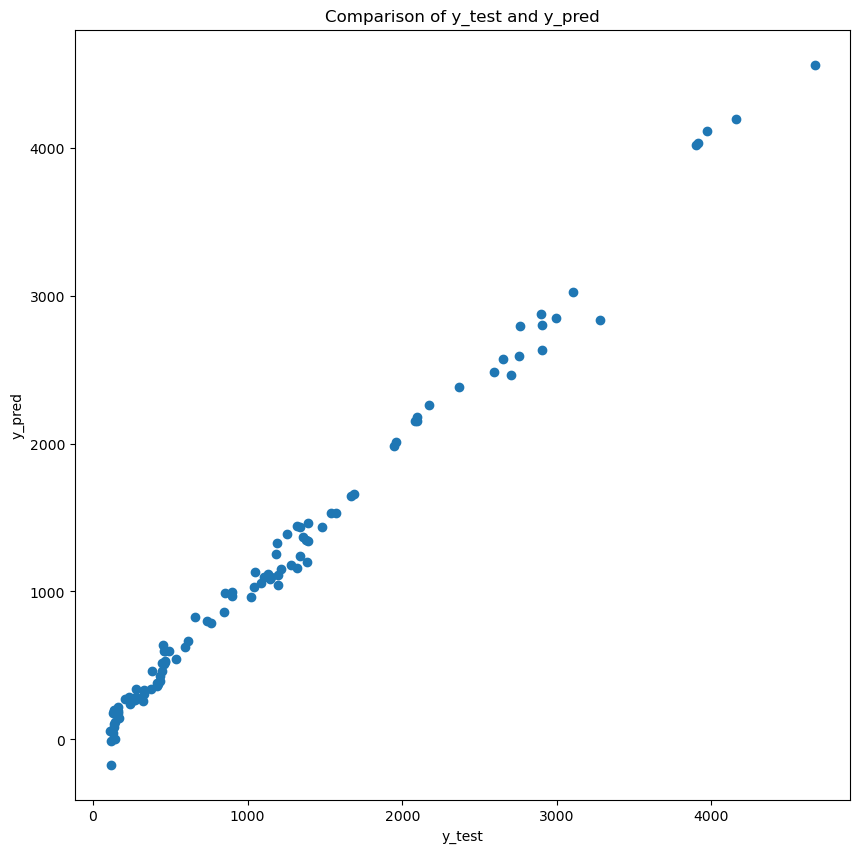

In [22]:
plt.figure(figsize=(10, 10))
plt.scatter(y_test, y_pred)
plt.xlabel("y_test")
plt.ylabel("y_pred")
plt.title("Comparison of y_test and y_pred")
plt.show();

In [23]:
mape(y_test, y_pred)

14.771153989729093

## 5.2. Feature Importance

In [24]:
features = []
for col in list(X_train.columns):
    features.append(tags_dict[col])

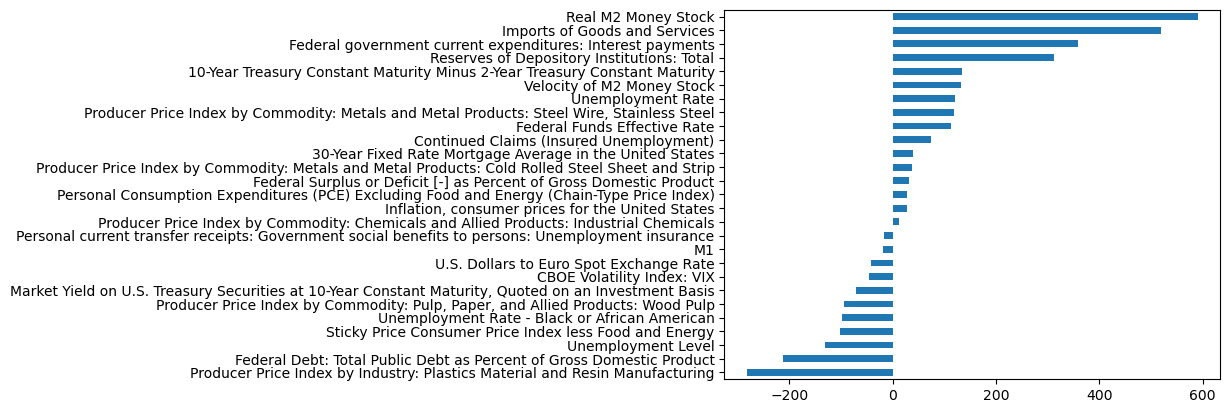

In [33]:
# Top 20 Features
top20_ridge = pd.Series(
    pipe_ridge.named_steps["ridge"].coef_.flatten(), 
    features
).sort_values(ascending=False)#.head(20)

top20_ridge.plot.barh().invert_yaxis()
plt.show();

# 6. Evaluation of `CatBoost` Model

In [26]:
pipe_catb.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('catboostregressor',
                 <catboost.core.CatBoostRegressor object at 0x0000026AC4738640>)])

In [27]:
shap.initjs()

In [28]:
catboost_explainer = shap.Explainer(pipe_catb.named_steps["catboostregressor"])

In [29]:
X_test_enc = pd.DataFrame(
    pipe_catb.named_steps["standardscaler"].transform(X_test),
    columns=features,
    index=X_test.index
)

In [30]:
shap_values = catboost_explainer(X_test_enc)

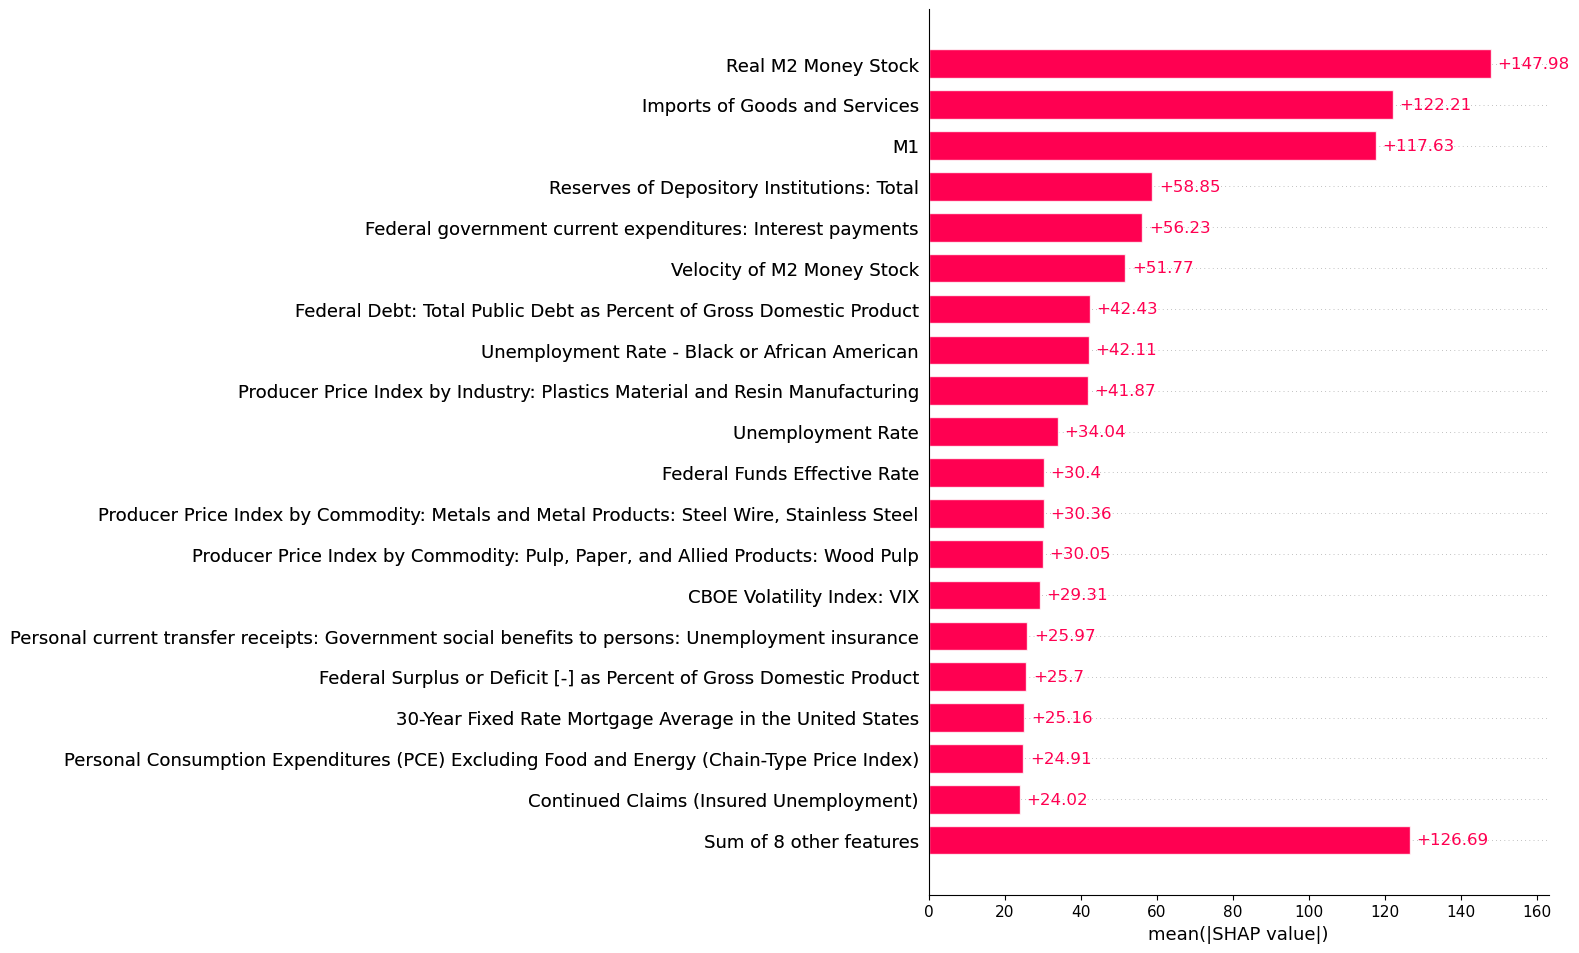

In [31]:
shap.plots.bar(shap_values, max_display=20)

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.


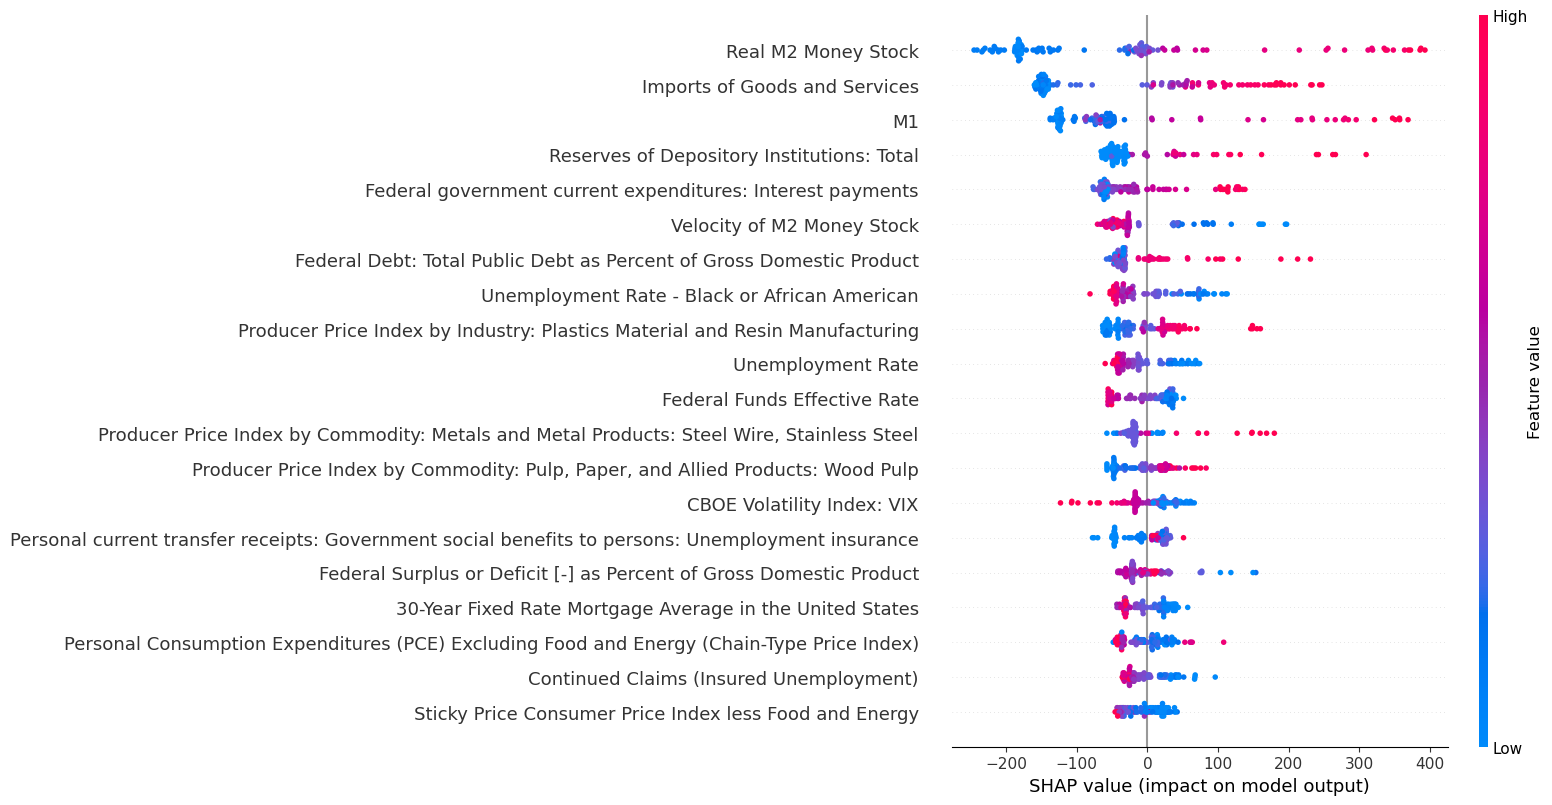

In [32]:
shap.summary_plot(shap_values)